# Term Deposit Prediction using Machine Learning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, roc_curve, auc, precision_recall_fscore_support
)
import warnings
warnings.filterwarnings("ignore")
sns.set(style="darkgrid") 

In [2]:
# Load dataset
path = "bank-full.csv"  
df = pd.read_csv(path, sep=';')

print("=== Dataset loaded from:", path, "===\n")

=== Dataset loaded from: bank-full.csv ===



In [3]:
# Q1: How many rows and columns are present in the dataset?
rows, cols = df.shape
print(f"Number of Rows: {rows}, Number of Columns: {cols}")
print("\n\n")

Number of Rows: 45211, Number of Columns: 17





In [4]:
# Q2: List all feature names. Which are numerical, which are categorical, and which are binary?
all_features = df.columns.tolist()
print("All features:", all_features)

# Detect types (simple heuristic: numeric dtype -> numerical; object dtype -> categorical. Binary: two unique values)
numerical = df.select_dtypes(include=[np.number]).columns.tolist()
categorical = df.select_dtypes(include=['object']).columns.tolist()
binary = [c for c in df.columns if df[c].nunique() == 2]
print("\nNumerical features:", numerical)
print("\nCategorical features:", categorical)
print("\nBinary features:", binary)
print("\n\n")

All features: ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y']

Numerical features: ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

Categorical features: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'y']

Binary features: ['default', 'housing', 'loan', 'y']





In [5]:
# Q3: Distribution of target variable y (yes vs no)
target_counts = df['y'].value_counts()
print(target_counts)
print("Proportions:")
print((target_counts / target_counts.sum()).round(4))
print("\n\n")

y
no     39922
yes     5289
Name: count, dtype: int64
Proportions:
y
no     0.883
yes    0.117
Name: count, dtype: float64





In [6]:
# Q4: Any missing values? If yes, report columns and counts
missing_counts = df.isnull().sum()
missing_counts = missing_counts[missing_counts > 0]
if missing_counts.empty:
    print("No NaN missing values detected.")
else:
    print("Missing (NaN) counts per column:\n", missing_counts)

# Additionally check for 'unknown' which in this dataset indicates missingness as a category
print("\nCounts of 'unknown' per categorical column:")
for c in categorical:
    if 'unknown' in df[c].values:
        print(c, ":", (df[c] == 'unknown').sum())
print("\n\n")

No NaN missing values detected.

Counts of 'unknown' per categorical column:
job : 288
education : 1857
contact : 13020
poutcome : 36959





In [7]:
# Q5: Summary statistics for numerical columns (mean, median, std, min, max)
num_stats = df[numerical].agg(['mean','median','std','min','max']).transpose()
print(num_stats.round(4))
print("\n\n")

               mean  median        std     min       max
age         40.9362    39.0    10.6188    18.0      95.0
balance   1362.2721   448.0  3044.7658 -8019.0  102127.0
day         15.8064    16.0     8.3225     1.0      31.0
duration   258.1631   180.0   257.5278     0.0    4918.0
campaign     2.7638     2.0     3.0980     1.0      63.0
pdays       40.1978    -1.0   100.1287    -1.0     871.0
previous     0.5803     0.0     2.3034     0.0     275.0





In [8]:
# Q6: For "job" column, counts of each category and most frequent job
job_counts = df['job'].value_counts()
print(job_counts)
most_freq_job = job_counts.idxmax()
print("\nMost frequent job category:", most_freq_job, f"({job_counts.max()} instances)")
print("\n\n")

job
blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
Name: count, dtype: int64

Most frequent job category: blue-collar (9732 instances)





In [9]:
# Q7: Which two numerical features are most positively correlated? Which are most negatively correlated?
corr_matrix = df[numerical].corr()
# Flatten matrix to pairs
corr_pairs = (
    corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    .stack()
    .sort_values()
)
most_neg = corr_pairs.index[0] if not corr_pairs.empty else None
most_pos = corr_pairs.index[-1] if not corr_pairs.empty else None
print("Top positive correlation pair:", most_pos," value: ", corr_pairs.max() if not corr_pairs.empty else None)
print("Top negative correlation pair:", most_neg," value: ", corr_pairs.min() if not corr_pairs.empty else None)
print("\nFull correlation matrix:\n", corr_matrix.round(3))
print("\n\n")

Top positive correlation pair: ('pdays', 'previous')  value:  0.4548196354805043
Top negative correlation pair: ('day', 'pdays')  value:  -0.09304407377294048

Full correlation matrix:
             age  balance    day  duration  campaign  pdays  previous
age       1.000    0.098 -0.009    -0.005     0.005 -0.024     0.001
balance   0.098    1.000  0.005     0.022    -0.015  0.003     0.017
day      -0.009    0.005  1.000    -0.030     0.162 -0.093    -0.052
duration -0.005    0.022 -0.030     1.000    -0.085 -0.002     0.001
campaign  0.005   -0.015  0.162    -0.085     1.000 -0.089    -0.033
pdays    -0.024    0.003 -0.093    -0.002    -0.089  1.000     0.455
previous  0.001    0.017 -0.052     0.001    -0.033  0.455     1.000





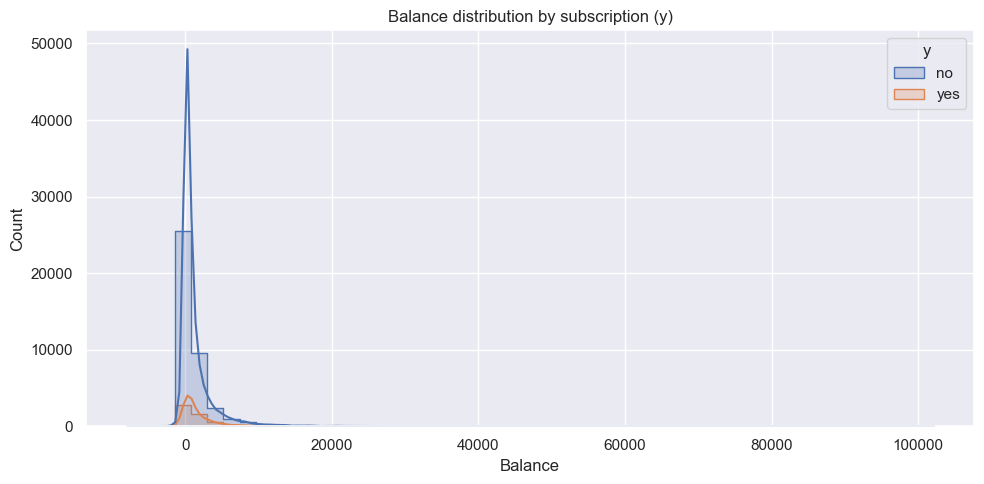

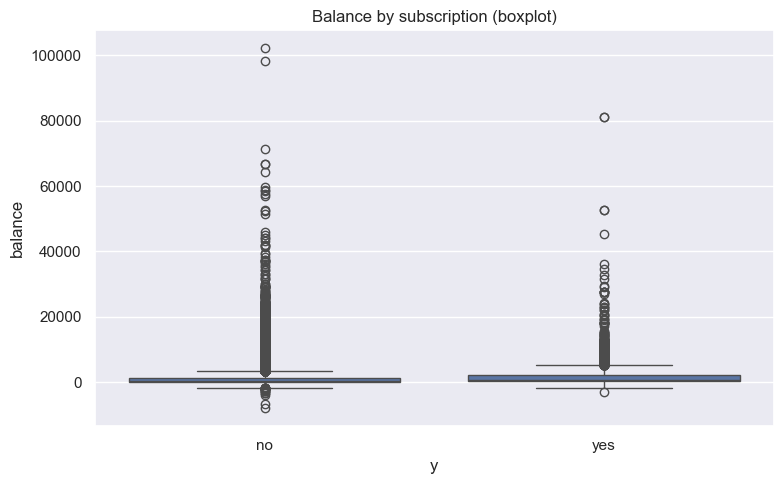

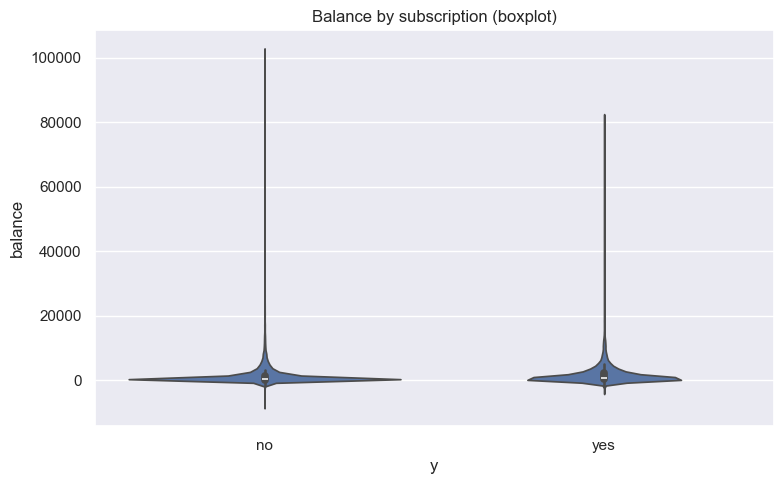

In [10]:
# Q8: Compare distribution of "balance" for clients who subscribed vs who did not
plt.figure(figsize=(10,5))
sns.histplot(data=df, x='balance', hue='y', kde=True, element='step', stat='count', bins=50)
plt.title("Balance distribution by subscription (y)")
plt.xlabel("Balance")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Also show boxplots to compare medians and outliers
plt.figure(figsize=(8,5))
sns.boxplot(x='y', y='balance', data=df)
plt.title("Balance by subscription (boxplot)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,5))
sns.violinplot(x='y', y='balance', data=df)
plt.title("Balance by subscription (boxplot)")
plt.tight_layout()
plt.show()
print("\n\n")

In [11]:
# Q9: For "education" column, subscription rate for each category and highest rate
if 'education' in df.columns:
    edu_group = df.groupby('education')['y'].value_counts().unstack(fill_value=0)
    edu_group['total'] = edu_group.sum(axis=1)
    if 'yes' in edu_group.columns:
        edu_group['subscribe_rate'] = edu_group['yes'] / edu_group['total']
    else:
        edu_group['subscribe_rate'] = 0.0
    edu_rates = edu_group[['total','yes','subscribe_rate']].sort_values('subscribe_rate', ascending=False)
    print(edu_rates.round(4))
    best_edu = edu_rates['subscribe_rate'].idxmax()
    print("\nEducation group with highest subscription rate:", best_edu, "rate =", edu_rates.loc[best_edu,'subscribe_rate'])
else:
    print("No 'education' column found in dataset.")
print("\n\n")

y          total   yes  subscribe_rate
education                             
tertiary   13301  1996          0.1501
unknown     1857   252          0.1357
secondary  23202  2450          0.1056
primary     6851   591          0.0863

Education group with highest subscription rate: tertiary rate = 0.15006390496955116





In [12]:
# Q10: One-hot encode "marital" and show transformed columns
marital_dummies = pd.get_dummies(df['marital'], prefix='marital')
print("New columns from one-hot encoding:", marital_dummies.columns.tolist())
print("Sample of transformed columns (first 5 rows):")
print(marital_dummies.head())
print("\n\n")

New columns from one-hot encoding: ['marital_divorced', 'marital_married', 'marital_single']
Sample of transformed columns (first 5 rows):
   marital_divorced  marital_married  marital_single
0             False             True           False
1             False            False            True
2             False             True           False
3             False             True           False
4             False            False            True





In [13]:
# Q11: Split the data into train and test sets (80-20). Report counts
# Prepare feature matrix X and target y
X = df.copy()
y = X.pop('y').map({'yes':1, 'no':0})  # map to 0/1
# For simplicity, convert categorical columns to numeric using simple label encoding (so models run quickly)
X_simple = X.copy()
for col in X_simple.select_dtypes(include=['object']).columns:
    X_simple[col] = LabelEncoder().fit_transform(X_simple[col].astype(str))
X_train, X_test, y_train, y_test = train_test_split(X_simple, y, test_size=0.2, stratify=y, random_state=42)
print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])
print("\n\n")

Training samples: 36168
Testing samples: 9043





In [14]:
# Q12: Train Logistic Regression. Report metrics on test set.
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
acc_lr = accuracy_score(y_test, y_pred_lr)
prec_lr = precision_score(y_test, y_pred_lr, zero_division=0)
rec_lr = recall_score(y_test, y_pred_lr, zero_division=0)
f1_lr = f1_score(y_test, y_pred_lr, zero_division=0)
print("Logistic Regression — Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}".format(
    acc_lr, prec_lr, rec_lr, f1_lr))
print("\nClassification report:\n", classification_report(y_test, y_pred_lr, digits=4))
print("\n\n")

Logistic Regression — Accuracy: 0.8897, Precision: 0.5822, Recall: 0.2042, F1: 0.3023

Classification report:
               precision    recall  f1-score   support

           0     0.9029    0.9806    0.9401      7985
           1     0.5822    0.2042    0.3023      1058

    accuracy                         0.8897      9043
   macro avg     0.7426    0.5924    0.6212      9043
weighted avg     0.8654    0.8897    0.8655      9043






In [15]:
# Q13: Train Random Forest classifier. Report same metrics and compare
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)
prec_rf = precision_score(y_test, y_pred_rf, zero_division=0)
rec_rf = recall_score(y_test, y_pred_rf, zero_division=0)
f1_rf = f1_score(y_test, y_pred_rf, zero_division=0)
print("Random Forest — Accuracy: {:.4f}, \n Precision: {:.4f},\n Recall: {:.4f},\n F1: {:.4f}".format(
    acc_rf, prec_rf, rec_rf, f1_rf))
print("\nClassification report:\n", classification_report(y_test, y_pred_rf, digits=4))

Random Forest — Accuracy: 0.9053, 
 Precision: 0.6540,
 Recall: 0.4055,
 F1: 0.5006

Classification report:
               precision    recall  f1-score   support

           0     0.9250    0.9716    0.9477      7985
           1     0.6540    0.4055    0.5006      1058

    accuracy                         0.9053      9043
   macro avg     0.7895    0.6885    0.7241      9043
weighted avg     0.8933    0.9053    0.8954      9043



In [16]:
print("\nComparison (test set):")
print(f"Accuracy: LR {acc_lr:.4f} vs RF {acc_rf:.4f}")
print(f"Precision: LR {prec_lr:.4f} vs RF {prec_rf:.4f}")
print(f"Recall: LR {rec_lr:.4f} vs RF {rec_rf:.4f}")
print(f"F1-score: LR {f1_lr:.4f} vs RF {f1_rf:.4f}")
print("\n\n")


Comparison (test set):
Accuracy: LR 0.8897 vs RF 0.9053
Precision: LR 0.5822 vs RF 0.6540
Recall: LR 0.2042 vs RF 0.4055
F1-score: LR 0.3023 vs RF 0.5006





In [17]:
# Q14: Top three important features in Random Forest
feat_importances = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
top3 = feat_importances.head(3)
print(top3)
print("\nInterpretation:\nThe three most important features in the Random Forest model are duration, balance, and age. \nAmong these, duration has the highest importance (0.29), indicating that the length of contact \nis the strongest predictor of whether a client will subscribe to a term deposit. \nBalance (0.11) and age (0.10) also contribute significantly, suggesting that financial status and age \ngroup influence the likelihood of subscription.")
print("\n\n")

duration    0.292823
balance     0.109880
age         0.103779
dtype: float64

Interpretation:
The three most important features in the Random Forest model are duration, balance, and age. 
Among these, duration has the highest importance (0.29), indicating that the length of contact 
is the strongest predictor of whether a client will subscribe to a term deposit. 
Balance (0.11) and age (0.10) also contribute significantly, suggesting that financial status and age 
group influence the likelihood of subscription.





In [18]:
# Q15: Adjust decision threshold for Random Forest (0.5, 0.4, 0.3). Report recall and precision
y_proba_rf = rf.predict_proba(X_test)[:,1]
thresholds = [0.5, 0.4, 0.3]
for thr in thresholds:
    y_pred_thr = (y_proba_rf >= thr).astype(int)
    prec = precision_score(y_test, y_pred_thr, zero_division=0)
    rec = recall_score(y_test, y_pred_thr, zero_division=0)
    f1 = f1_score(y_test, y_pred_thr, zero_division=0)
    print(f"Threshold {thr}: Precision={prec:.4f}, Recall={rec:.4f}, F1={f1:.4f}")
print("\n\n")

Threshold 0.5: Precision=0.6534, Recall=0.4187, F1=0.5104
Threshold 0.4: Precision=0.5963, Recall=0.6030, F1=0.5996
Threshold 0.3: Precision=0.5356, Recall=0.7391, F1=0.6211





Random Forest AUC: 0.9271


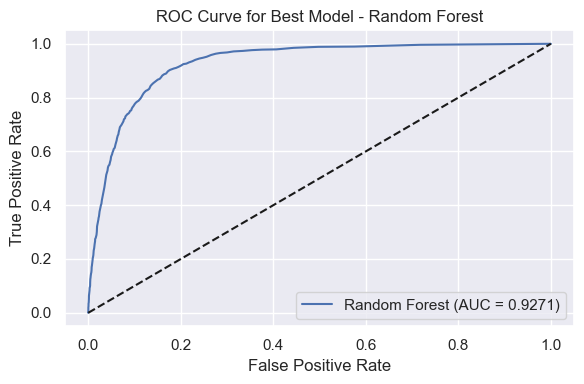

In [19]:
# Q16: Plot ROC curve for the best model and report AUC score.

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
auc_rf = auc(fpr_rf, tpr_rf)

print(f"Random Forest AUC: {auc_rf:.4f}")

plt.figure(figsize=(6,4))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.4f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Best Model - Random Forest')
plt.legend()
plt.tight_layout()
plt.show()